In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from google.colab import drive
from typing import Literal, Dict, Optional, Union


In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv(r'drive/MyDrive/resources/nn-project/penguins.csv')
data.head()

,Species,CulmenLength,CulmenDepth,FlipperLength,OriginLocation,BodyMass
0,Adelie,39.1,18.7,181.0,Torgersen,3750.0
1,Adelie,39.5,17.4,186.0,Torgersen,3800.0
2,Adelie,40.3,18.0,195.0,Torgersen,3250.0
3,Adelie,NaN,NaN,NaN,Torgersen,NaN
4,Adelie,36.7,19.3,193.0,Torgersen,3450.0


In [ ]:
data.duplicated().sum()

np.int64(0)

In [ ]:
display(data.shape)
_features_to_select_from = ', '.join(data.columns.tolist()[1:])

(150, 6)

In [ ]:
target_column = 'Species'

In [ ]:
features = input(f"Please specify any 2 features (Comma-Separated)\n{_features_to_select_from}: ").split(', ')
assert len(features) == 2, "Please specify ONLY 2 features."

Please specify any 2 features (Comma-Separated)
CulmenLength, CulmenDepth, FlipperLength, OriginLocation, BodyMass: CulmenLength, CulmenDepth


In [ ]:
print("Features you chose are: ", features)

Features you chose are:  ['CulmenLength', 'CulmenDepth']


In [ ]:
features_and_target = features + [target_column]

In [ ]:
data = data[features_and_target]
data.head()

,CulmenLength,CulmenDepth,Species
0,39.1,18.7,Adelie
1,39.5,17.4,Adelie
2,40.3,18.0,Adelie
3,NaN,NaN,Adelie
4,36.7,19.3,Adelie


In [ ]:
_classes_to_choose_from = ', '.join(data[target_column].unique())

In [ ]:
classes = input(f"Please specify any 2 classes (Comma-Separated)\n{_classes_to_choose_from}: ").split(', ')
assert len(classes) == 2, "Please specify ONLY 2 classes."

Please specify any 2 classes (Comma-Separated)
Adelie, Chinstrap, Gentoo: Adelie, Chinstrap


In [ ]:
print("Classes you chose are: ", classes)

Classes you chose are:  ['Adelie', 'Chinstrap']


In [ ]:
data = data[data[target_column].isin(classes)]
data[target_column] = data[target_column].astype('category')
data.shape

(100, 3)

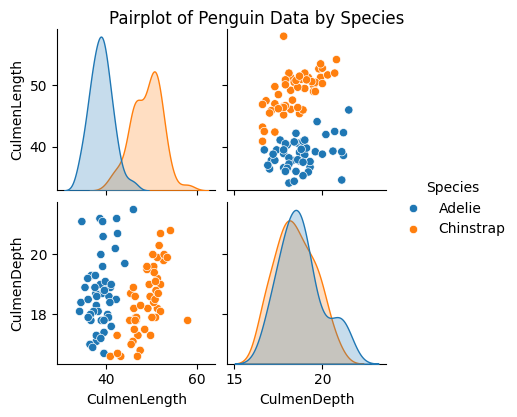

In [ ]:
# Visualize relationships between numerical features and the target variable using pairplot
sns.pairplot(data, hue='Species', height=2)
plt.suptitle('Pairplot of Penguin Data by Species', y=1.02)
plt.show()

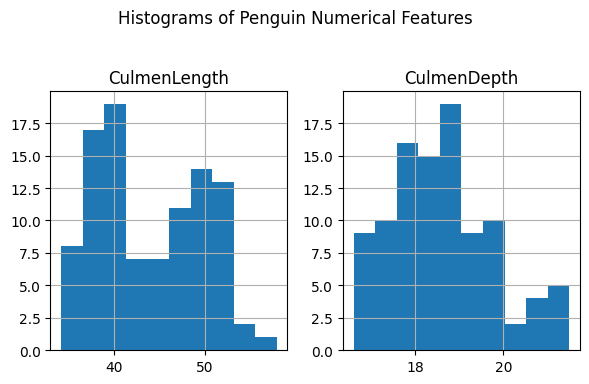

In [ ]:
# Visualize the distribution of each numerical feature using histograms
numerical_features = data.select_dtypes(include=np.number).columns.tolist()
num_features = len(numerical_features)

data[numerical_features].hist(figsize=(4, 4) if num_features == 1 else (6, 4))
plt.suptitle('Histograms of Penguin Numerical Features')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

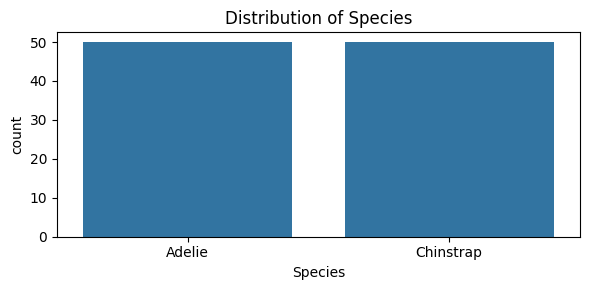

In [ ]:
# Visualize the distribution of categorical features using countplots
# Determine the number of subplots based on the presence of 'OriginLocation'
num_subplots = 1 + ('OriginLocation' in data.columns)
fig, axes = plt.subplots(1, num_subplots, figsize=(6 * num_subplots, 3))

# Ensure axes is iterable even if there's only one subplot
if num_subplots == 1:
  axes = [axes]

sns.countplot(x='Species', data=data, ax=axes[0])
axes[0].set_title('Distribution of Species')

if 'OriginLocation' in data.columns:
  data['OriginLocation'] = data['OriginLocation'].astype('category')

  sns.countplot(x='OriginLocation', data=data, ax=axes[1])
  axes[1].set_title('Distribution of Origin Location')

plt.tight_layout()
plt.show()

In [ ]:
nulls = data.isnull().sum()
nulls

,0
CulmenLength,1
CulmenDepth,1
Species,0


In [ ]:
# filling by mean
_mean = data.mean(numeric_only=True)
print(f"Filling null values with mean:")
display(_mean)
data = data.fillna(_mean)
data.isnull().sum()

Filling null values with mean:


,0
CulmenLength,43.918182
CulmenDepth,18.608081


,0
CulmenLength,0
CulmenDepth,0
Species,0


In [ ]:
# since target model is adaline or perceptron (Linear models)
# therefore one hot encoding is best
# OriginLocation
# our target column is 'Species' we will make to it labelencoder
# 0 for 'Adelie' or 1 for 'Gentoo' or 2 for 'Chinstrap'
categorical_columns = []
if 'OriginLocation' in data.columns:
  categorical_columns.append('OriginLocation')

# changed this without dropping
data_encoded = data.loc[:, data.columns != target_column]

if categorical_columns:
  enc = OneHotEncoder(sparse_output=False)
  encoding = enc.fit_transform(data[categorical_columns])
  cat_feature_names = enc.get_feature_names_out(categorical_columns)

  encoding = pd.DataFrame(encoding, columns=cat_feature_names, index=data_encoded.index)
  data_encoded = data_encoded.drop(columns=categorical_columns)
  data_encoded = pd.concat([data_encoded, encoding], axis=1)

data_encoded

,CulmenLength,CulmenDepth
0,39.100000,18.700000
1,39.500000,17.400000
2,40.300000,18.000000
3,43.918182,18.608081
4,36.700000,19.300000
...,...,...
95,50.800000,18.500000
96,50.100000,17.900000
97,49.000000,19.600000
98,51.500000,18.700000


In [ ]:
le = LabelEncoder()
y_enc = le.fit_transform(data[target_column])
len(y_enc)

100

# Splitting data to train and test samples

### Note on `test_size` Parameter.
Changed `test_size` from **0.2** to **0.4**. This adjustment is based on the requirement that each sample class should have 30 samples for training and 20 for testing.

Given that each class has 50 samples total and we are using 2 classes:
* **Total Training:** 30 samples/class * 2 classes = 60 samples
* **Total Testing:** 20 samples/class * 2 classes = 40 samples
* **Total Dataset:** 50 samples/class * 2 classes = 100 samples

This results in a testing ratio of 40 / 100, so `test_size` is set to **0.4**.

In [ ]:
x = data_encoded
y = y_enc

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [ ]:
y_train

array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

# Single Layer Perceptron / Adaptive Linear Neuron (Adaline) Training

## Initialize weights and bias

Initialize the weight vector `w` and bias `b` with random values or specific values (currently 1.5) using NumPy.

In [ ]:
def initialize_weights_and_bias(x, random: bool = False):
  if random:
    w = np.random.rand(x.shape[1])
    b = np.random.rand(1)[0]
    return w, b

  w = np.ones(x.shape[1]) * 1.5
  b = 0
  return w, b

## Define the activation function (the `signum` function)


In [ ]:
signum = lambda x: 1 if x >= 0 else -1

## Implement the training loop with defining a criterion

Determine when to stop the training process (ex: when no misclassifications occur in an epoch).


In [ ]:
def train(
    _x_train: np.array,
    _y_train: np.array,
    _w: np.array,
    _b: np.array,
    algorithm: Literal['perceptron', 'adaline'] = 'perceptron',
    epochs: int = 5,
    learning_rate: float = 0.01,
    threshold: Union[int, float] = 0
):
  errors, mse_values = [], []

  if (algorithm := algorithm.lower()) not in ['perceptron', 'adaline']:
    raise ValueError("Invalid algorithm. Use 'perceptron' or 'adaline'.")

  print(f"Training using ({algorithm.title()}) algorithm")

  for epoch in range(epochs):
    n_errors, epoch_mse = 0, 0

    for _x, _label in zip(_x_train, _y_train):
      linear_output = np.dot(_x, _w) + _b

      if algorithm == 'perceptron':
        y = signum(linear_output)
        target_signum = 1 if _label == 1 else -1

        if target_signum == y:
          continue

        update = learning_rate * (target_signum - y)
        _w += update * _x
        _b += update
        n_errors += 1
      elif algorithm == 'adaline':
        y = linear_output # linear activation
        update = learning_rate * (_label - y)
        _w += update * _x
        _b += update
        epoch_mse += (_label - y)**2 # mean squared error (MSE)

    # Define stopping criterion for each algorithm
    if algorithm == 'perceptron':
      errors.append(n_errors)
      if n_errors == threshold:
        print(f"{algorithm.title()} training converged at epoch {epoch + 1}")
        break
    elif algorithm == 'adaline':
      mse_values.append(mse := epoch_mse / len(_x_train))
      print(f"Epoch {epoch + 1}, MSE: {mse:.4f}")
      if mse < threshold:
        print(f"{algorithm.title()} training converged at epoch {epoch + 1}")
        break


  print("Training complete.")
  if algorithm == 'perceptron':
    return errors, (_w, _b)
  elif algorithm == 'adaline':
    return mse_values, (_w, _b)
  raise ValueError(f"Invalid algorithm = {algorithm.title()}. Use 'perceptron' or 'adaline'.")

## Steps

In [ ]:
# w, b = initialize_weights_and_bias(x_train_scaled, random=True)
# errors, wb = train(x_train_scaled, y_train, w, b, algorithm='perceptron', epochs=10, learning_rate=0.01, threshold=0)

w, b = initialize_weights_and_bias(x_train_scaled)
errors, wb = train(x_train_scaled, y_train, w, b, algorithm='adaline', epochs=5, learning_rate=0.005, threshold=0.2)

Training using (Adaline) algorithm
Epoch 1, MSE: 3.3622
Epoch 2, MSE: 1.7491
Epoch 3, MSE: 0.9232
Epoch 4, MSE: 0.4999
Epoch 5, MSE: 0.2827
Training complete.


In [ ]:
_n_errors = 5
print(f"First {_n_errors} errors: {errors[:_n_errors]}")

First 5 errors: [np.float64(3.3622074994634117), np.float64(1.7490822472908427), np.float64(0.9231656849977464), np.float64(0.49986283284150174), np.float64(0.2826600598854274)]


## Evaluate the model

In [ ]:
# Calculate linear output for the test set
updated_w, updated_b = wb
linear_output_test = np.dot(x_test_scaled, updated_w) + updated_b
# Apply signum activation function and convert to original target encoding
# This works for both Perceptron and Adaline when evaluating classification accuracy.
# Perceptron uses signum during training, Adaline uses linear output.
# For evaluation of classification, we apply signum to the linear output for both.
# signum returns 1 or -1. Original target encoding is 0 or 1.
# If signum output is 1, predicted class is 1. If signum output is -1, predicted class is 0.
y_pred_test = np.array([1 if signum(output) == 1 else 0 for output in linear_output_test])

print("Predicted Values:\t", y_pred_test[:-5])
print("Actual Values:\t\t", y_test[:-5])

accuracy = np.mean(y_pred_test == y_test)

print(f"Accuracy on the test set: {accuracy * 100}%")

Predicted Values:	 [1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0 1]
Actual Values:		 [1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1]
Accuracy on the test set: 82.5%


# Plotting

## Plot the decision boundary

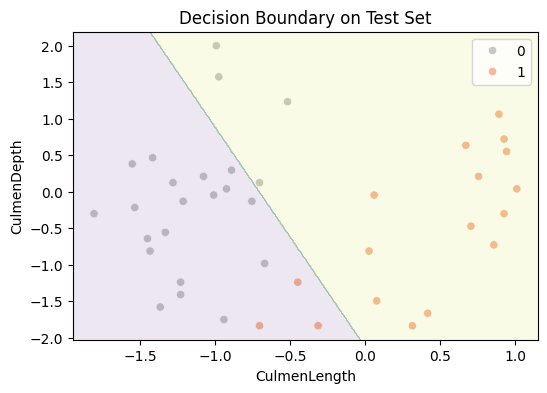

In [ ]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x=x_test_scaled[:, 0], y=x_test_scaled[:, 1], hue=y_test, palette='RdGy_r', legend='full')

ax = plt.gca()
xlim, ylim = ax.get_xlim(), ax.get_ylim()

yy, xx = np.linspace(ylim[0], ylim[1], 500), np.linspace(xlim[0], xlim[1], 500)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()])

# Test every point on the grid with 50 * 50 points
# using the weights and biases from the model.
grid_test = np.dot(updated_w.T, xy) + updated_b
grid_test = np.array([1 if signum(output) == 1 else 0 for output in grid_test]).reshape(XX.shape)

ax.contourf(XX, YY, grid_test, alpha=0.1)

plt.title('Decision Boundary on Test Set')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.show()

## Displaying Errors

In [ ]:
y_pred_decoded = le.inverse_transform(y_pred_test)
y_test_decoded = le.inverse_transform(y_test)

errors_df = pd.DataFrame({
    **{feature: x_test.iloc[:, i] for i, feature in enumerate(features)},
    'Actual Species': y_test_decoded,
    'Predicted Species': y_pred_decoded,
    'Error': y_test_decoded != y_pred_decoded
})

errors_df[errors_df['Error']].reset_index(drop=True)

,CulmenLength,CulmenDepth,Actual Species,Predicted Species,Error
0,42.4,17.3,Chinstrap,Adelie,True
1,40.9,16.6,Chinstrap,Adelie,True
2,40.9,18.9,Adelie,Chinstrap,True
3,42.0,20.2,Adelie,Chinstrap,True
4,43.2,16.6,Chinstrap,Adelie,True
5,39.3,20.6,Adelie,Chinstrap,True
6,39.2,21.1,Adelie,Chinstrap,True
